<center>
    <h1> Scientific Programming in Python  </h1>
    <h2> Topic 3: Handling Very Large Arrays, Memory Mappings </h2> 
</center>

_Notebook created by Martín Villanueva - `martin.villanueva@usm.cl` - DI UTFSM - April 2017._

In [30]:
%matplotlib inline
%load_ext memory_profiler

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
import sys
import h5py


def get_size(obj, seen=None):
    """
    Recursively finds size of objects
    ref: https://goshippo.com/blog/measure-real-size-any-python-object/
    """
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Table of Contents
* [0.- Memory Profiling](#mem)
* [1.- Very Large Arrays](#larray)
* [2.- NumPy's Memory Mappings](#memmap)
* [3.- HDF5 and h5py](#hdf5)
* [4.- Sparse Matrices](#sparse)

<div id='mem' />
## Memory Profiling

In order to use the `memit` magic, you have to install the `memory_profiler` module, with one of this commands:
```Bash
conda install memory_profiler
pip install memory_profiler
```

In [3]:
%memit?

Measure memory usage of a Python statement

Usage, in line mode:
```Python
  %memit [-r<R>t<T>i<I>] statement
```


Usage, in cell mode:
```Python
  %%memit [-r<R>t<T>i<I>] setup_code
  code...
  code...
```


This function can be used both as a line and cell magic:

- In line mode you can measure a single-line statement (though multiple
  ones can be chained with using semicolons).

- In cell mode, the statement in the first line is used as setup code
  (executed but not measured) and the body of the cell is measured.
  The cell body has access to any variables created in the setup code.

Options:

-r<R>: repeat the loop iteration <R> times and take the best result.
Default: 1

-t<T>: timeout after <T> seconds. Default: None

-i<I>: Get time information at an interval of I times per second.
    Defaults to 0.1 so that there is ten measurements per second.

-c: If present, add the memory usage of any children process to the report.

-o: If present, return a object containing memit run details

-q: If present, be quiet and do not output a result.

Examples
--------
::
```Python
  In [1]: %memit range(10000)
  peak memory: 21.42 MiB, increment: 0.41 MiB

  In [2]: %memit range(1000000)
  peak memory: 52.10 MiB, increment: 31.08 MiB

  In [3]: %%memit l=range(1000000)
     ...: len(l)
     ...:
  peak memory: 52.14 MiB, increment: 0.08 MiB
```

In [4]:
%memit  np.ones((100,100), dtype=np.float64)

peak memory: 69.62 MiB, increment: 5.73 MiB


<div id='larray' />
## 1.- Very Large Arrays

`numpy.arrays` are meant __to live in memory__. If you want to work with matrices __larger than your RAM__, you have to work around that. There are at least two approaches you can follow:

1. __Try a more efficient matrix representation__ that exploits any special structure that your matrices have. For example, there are efficient data structures for __sparse matrices__ (matrices with lots of zeros), like `scipy.sparse.csc_matrix`.
2. __Modify your algorithm to work on submatrices__. You can read from disk only the __matrix blocks__ that are currently being used in computations. Algorithms designed to run on clusters usually work blockwise, since the data is scatted across different computers, and passed by only when needed.

<div id='memmap' />
## 2.- NumPy's Memory Mappings

Some important features of __Memory Mappings__:

1. Memory mapping lets you work with huge arrays almost as if they were regular arrays.
2. Python code that accepts a NumPy array as input will also accept a memmap array.
3. We need to ensure that the array is used __efficiently__, i.e, the array is never loaded as a whole.
4. This method is not the most adapted for long-term storage of data and data sharing (__HDF5 is it!__).

1.- Let's create a memory-mapped array:

In [5]:
nrows, ncols = 100, 1000000
f = np.memmap('memmapped.dat', dtype=np.float32, mode='w+', shape=(nrows, ncols))

print(type(f))

<class 'numpy.core.memmap.memmap'>


2.- Let's feed the array with random values, one column at a time because our system's memory is limited! (__Reducing garbage collector work__)

In [6]:
%%memit
for i in range(nrows):
    tmp = np.random.random(ncols)
    f[i,:] = tmp
    del tmp

peak memory: 453.55 MiB, increment: 389.14 MiB


In [7]:
%%memit
np.random.random((nrows,ncols))

peak memory: 1211.78 MiB, increment: 758.22 MiB


We save the last column of the array:

In [8]:
x = f[-1,:]

3.- Now, we flush memory changes to disk by deleting the object:

In [10]:
del f

4.- Reading a memory-mapped array from disk involves the same `memmap` function. The `data type` and the `shape` need to be specified again, as this information is not stored in the file:

In [14]:
%%memit 
f = np.memmap('memmapped.dat', dtype=np.float32, shape=(nrows, ncols))

peak memory: 453.57 MiB, increment: 0.00 MiB


In [15]:
%%memit
np.array_equal(f[-1,:],x)

peak memory: 458.37 MiB, increment: 4.79 MiB


In [16]:
print(type(f[-1,:]))

<class 'numpy.core.memmap.memmap'>


<div id='hdf5' />
## 3.- HDF5 and `h5py`

__Why HD5 instead of native NumPy's memmap:__

1. __HDF5__ (_Hierarchical Data Format version 5_) is an open format specification, i.e, language independet. Can be used with Python, Matlab, R, C, Java, etc.
2. HDF5 not only implement _memory mappings_ but also provides a POSIX-like hierarchy to organize different arrays.
3. It is more versatile than NumPy's memmap. The latter (`numpy.memmap`) stores the array in binary form on the hard-disk using contiguous blocks of memory. The first (`hdf5`) work with __chunks__ (which are atomic objects) organized in a __B-tree__ structure. _The content of a chunk is contiguously stored in the hard-disk_.

There are two libraries to work with `HDF5` in Python: `PyTables` and `h5py`. We use the second one since it is more lightweight and more adapted than `PyTables`in some situations.

1.- Let's create a new empty `HDF5` file:

In [40]:
f = h5py.File("myfile.h5", "w")

2.- We create a `1000x1000` array (just the memory mapping in fact...)

In [41]:
nrows = 100
ncols = 1000000
dset = f.create_dataset("dataset", (nrows,ncols), dtype='f')

In [42]:
print(type(dset))
print(dset.shape)
print(dset.dtype)

<class 'h5py._hl.dataset.Dataset'>
(100, 1000000)
float32


3.- We now fill it with random values

In [43]:
%%memit
for i in range(nrows):
    tmp = np.random.random(ncols)
    dset[i,:] = tmp
    del tmp

peak memory: 94.61 MiB, increment: 1.00 MiB


In [44]:
%%memit
a = np.random.random((nrows,ncols))

peak memory: 766.39 MiB, increment: 671.78 MiB


In [47]:
# we will store the last row
x = dset[-1,:]
print(type(x))

<class 'numpy.ndarray'>


### About groups and hierarchical organization...

An HDF5 file is a container for two kinds of objects: datasets, which are array-like collections of data, and groups, which are folder-like containers that hold datasets and other groups. The most fundamental thing to remember when using h5py is:

__Groups work like folders, and datasets work like NumPy arrays!__

<img src='data/hdf5.jpg' style="width: 600px;">



In [48]:
# The File object we created is itself a group, in this case the root group
print( f.name )
print( dset.name )

/
/dataset


In [49]:
# Lets create a subgroup
f.create_group("subgroup")

<HDF5 group "/subgroup" (0 members)>

In [50]:
# Lets create a new dataset inside this subgroup
dset2 = f.create_dataset('subgroup/dataset2', (10,), dtype='i')
print(dset2.name)

/subgroup/dataset2


In [51]:
# Retrieving datasets/arrays from hdf5 file
print( f["dataset"] )
print( f["subgroup/dataset2"] )

<HDF5 dataset "dataset": shape (100, 1000000), type "<f4">
<HDF5 dataset "dataset2": shape (10,), type "<i4">


In [52]:
f.close()

Now lets re-open the `hdf5` file, and compare the last row:

In [61]:
%%memit
f = h5py.File("myfile.h5", "r+")
dset = f["dataset"]

peak memory: 157.50 MiB, increment: 0.00 MiB


In [62]:
%%memit
print(np.array_equal(dset[-1,:],x))

True
True
True
peak memory: 158.46 MiB, increment: 0.96 MiB


### A practical example: Huge matrix multiplication.

Supose we want to perform the dot product between $A \in \mathbb{R}^{m\times n}$ and $b \in \mathbb{R}^n$, such that $A$ doesn't fit in the available RAM memory. __How can we solve it? R: Memory Mappings__.

In [14]:
# We first create the hdf5 file, and add a dataset/array
nrows = 1000
ncols = 100000

f = h5py.File("test.h5", "w")
dset = f.create_dataset("array", (nrows,ncols), dtype='f')

In [19]:
%%memit
tmp = np.random.random((nrows,ncols))

peak memory: 911.36 MiB, increment: 762.95 MiB


We fill the array with random values, without loading the whole array

In [15]:
%%memit
for i in range(nrows):
    tmp = np.random.random(ncols)
    dset[i,:] = tmp
    del tmp  

peak memory: 145.04 MiB, increment: 1.75 MiB


Then we create the $b$ array and a $c$ empty array to store the results:

In [16]:
b = np.random.random(ncols)
c = np.empty(ncols)

And perform dot product without loading $A$ (completely) into main memory:

In [17]:
%%memit
for i in range(nrows):
    c[i] = np.dot(dset[i,:],b)

peak memory: 147.99 MiB, increment: 2.93 MiB


In [18]:
%%timeit
for i in range(nrows):
    c[i] = np.dot(dset[i,:],b)

1 loop, best of 3: 628 ms per loop


We save memory, but pay with overhead in time (_The time needed to retreive each row in `dset` into main memory_):

In [22]:
A = np.random.random((nrows,ncols))

In [23]:
%%timeit 
np.dot(A,b)

10 loops, best of 3: 63.6 ms per loop


__Note:__ The performance of _memory mapping_ approach can be improved by multiplying more than one row at each iteration!

### Chunking the datasets: Improving I/O performance

* An `hdf5` dataset created with the default settings will be contiguous; i.e, laid out on disk in __traditional C order__. 
* Datasets may also be created using `hdf5`’s _chunked storage layout_. This means the dataset is __divided up into regularly-sized pieces__ which are stored randomly on disk, and indexed using a __B-tree__.

__ We a single data of a chunk is indexed, the whole chunk is loaded (chunks are atomic)!__

In [88]:
# To enable chunked storage, set the keyword chunks to a tuple indicating the chunk shape
f = h5py.File("test2.h5", "w")
dset = f.create_dataset("chunked", (1000, 1000), chunks=(100, 100), dtype='f')

Data must be read and written now in blocks with shape (100,100): `dset[0:100,0:100]` for example.

__Trade-off:__ There is a trade-off between __many small chunks__ (large overhead due to managing lots of chunks) and a __few large chunks__ (inefficient disk I/O). The chunk size is recommended __to be smaller than 1 MB__.

<div id='sparse' />
## 4.- Sparse Matrices

A __sparse array__ is an array in which __most of the elements have the value 0__. The occurrence of zero-value elements in a large array is inefficient for both __computation__ and __storage__. An array in which there is a large number of zero elements is referred to as being sparse.

Such matrices appear naturally in many applications:
1. Finite Element Methods (PDEs solving method).
2. Finite Differences Methods (PDEs solving method).
3. Discrete Wavelet Transforms (Á trous)
4. Machine Learning: SVM and support vectors.
5. Machine Learning: Neural Networks (FeedForward) Weights.
6. Etc...

Generate a sparse matrix of the given `shape` and `density` with _randomly distributed values_:

In [59]:
nrows = 20
ncols = 20
A = sp.sparse.random(nrows, ncols, density=0.1, format='csr')
B = A.toarray()
print(type(A))
print(type(B))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


And we can visualize the matrix structure with `matplotlib.pyplot.matshow` function:

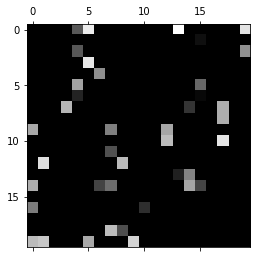

In [60]:
plt.figure(figsize=(15,15))
plt.matshow(B, cmap=plt.cm.gray)
plt.show()

### How sparse matrices are stored in memory?

__Answer:__ With _linkded lists_! (We just store the needed values in such lists). There are seven available sparse matrix types/formats:

1. __csc_matrix__: Compressed Sparse Column format
2. __csr_matrix__: Compressed Sparse Row format
3. __bsr_matrix__: Block Sparse Row format
4. __lil_matrix__: List of Lists format
5. __dok_matrix__: Dictionary of Keys format
6. __coo_matrix__: COOrdinate format (aka IJV, triplet format)
7. __dia_matrix__: DIAgonal format

#### CSR example

<img src='data/csr.svg' style="width: 600px;">

For more info see [Scipy Documentation](https://docs.scipy.org/doc/scipy/reference/sparse.html)

__Important note:__ Despite their similarity to NumPy arrays, it is strongly discouraged to use NumPy functions directly on these matrices because NumPy may not properly convert them for computations, leading to unexpected (and incorrect) results.



### A practical example again...

In [66]:
nrows = 1000
ncols = 100000
A = sp.sparse.random(nrows, ncols, density=0.1, format='csr')
B = A.toarray()
b = np.random.random(ncols)

In [87]:
print("Size of A:",get_size(A),"Bytes")
print("Size of B:",get_size(B),"Bytes")

Size of A: 4940 Bytes
Size of B: 800000368 Bytes


In [76]:
%timeit A.dot(b)

10 loops, best of 3: 24.2 ms per loop


In [78]:
%timeit B.dot(b)

10 loops, best of 3: 65 ms per loop
